In [1]:
from ift6758.data import wandb_handler
import ift6758.visualizations.baseline_models_figures as baseline_models_figures

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


Artifact downloaded to: ..\ift6758\ift6758\data\wandb_artifacts\test_set_feature_eng_1


wandb: Currently logged in as: andre-diler (IFT6758-2024-B05). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\ift6758\visualizations\baseline_models_figures.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile = df_percentiles.groupby('Percentile')['Actual'].apply(lambda x: x.sum() / len(x))
c:\users\dre\documents\agrosante_udem\cours\data_science\nhl project\ift-6758-project\ift6758\ift6758\visualizations\baseline_models_figures.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_goals = df_percentiles.groupby('Percentile')['Actual'].sum().cumsum()


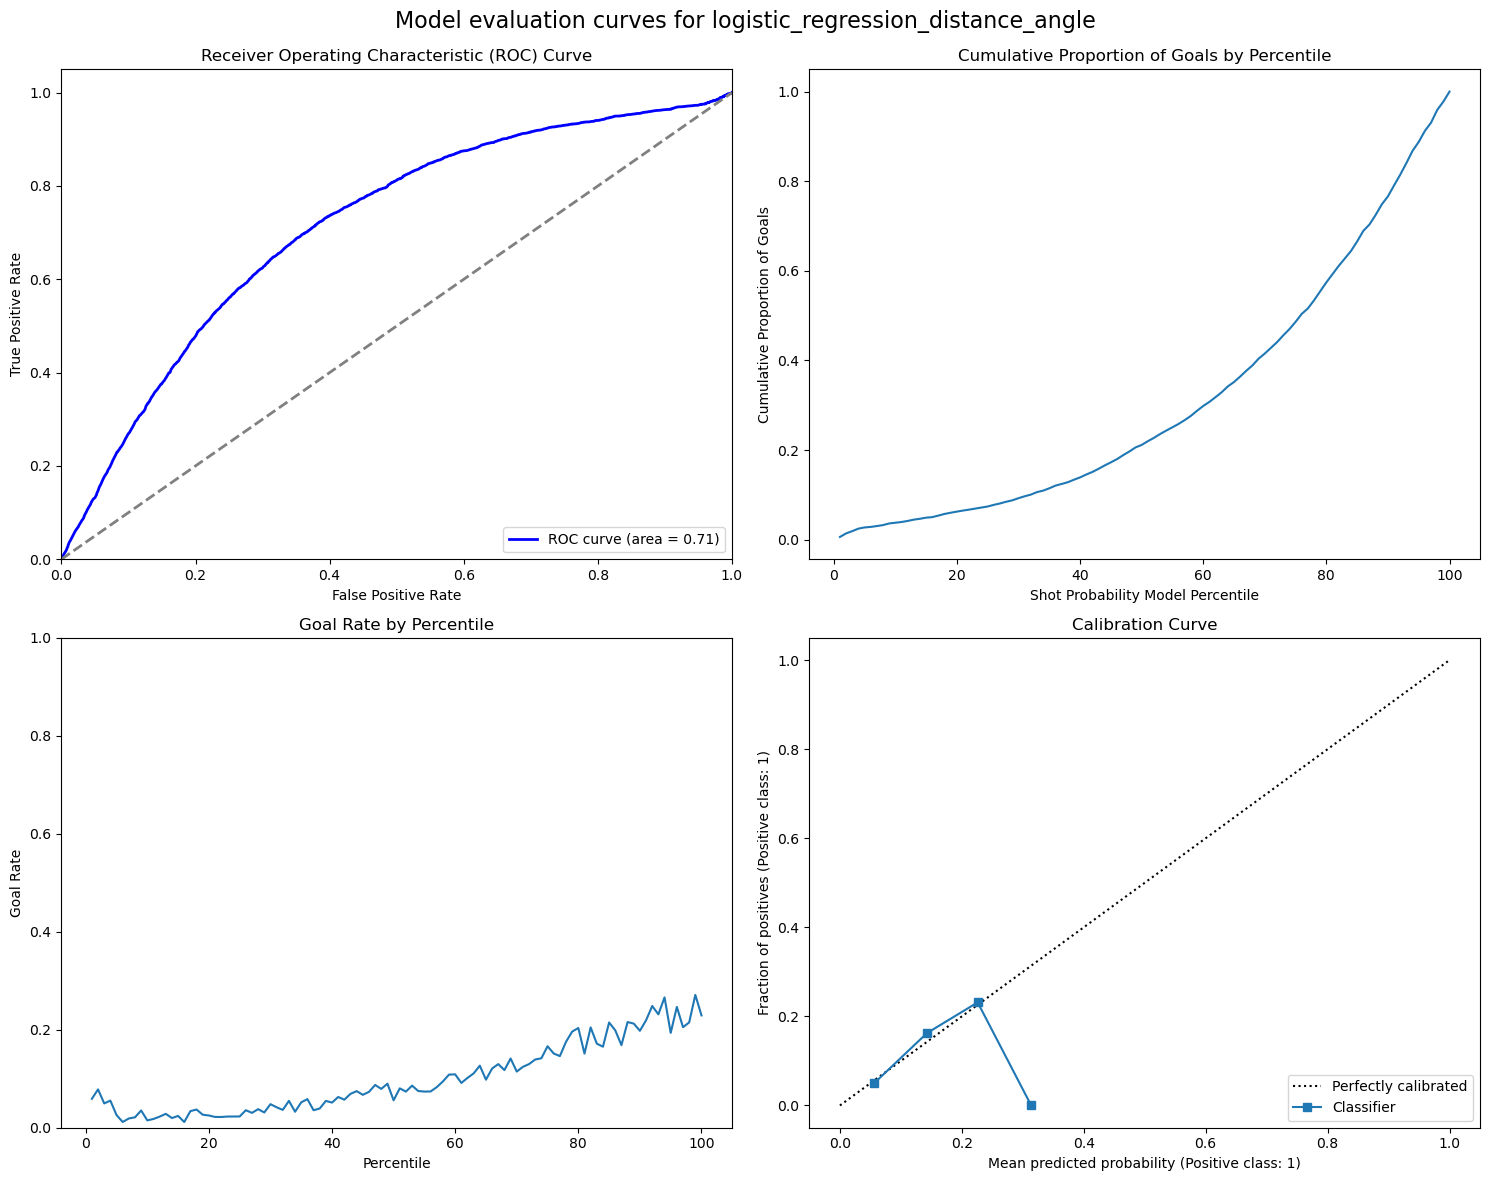

In [2]:
data_handler = wandb_handler.DataLoader()
model_handler = wandb_handler.ModelHandler()

features = ['distance', 'angle']
model_name = "logistic_regression_" + "_".join(features)

df = data_handler.load_all_files_from_artifact("test_set_feature_eng_1", "latest")
model = model_handler.load_model(model_name, "v0")

# no need for splitting because testing
X = df[features].to_numpy()
y_eval = df['is_goal'].to_numpy().reshape(-1, 1)

y_pred_discrete, y_pred_proba = model_handler.predict(model, X)


baseline_models_figures.plot_figures(y_pred_proba, y_eval, model_name)

In [3]:
model_list = model_handler.get_model_list()
print(model_list)

['logistic_regression_distance_angle:v0', 'logistic_regression_angle:v0', 'logistic_regression_distance:v0', 'run-gyn1tubx-logistic_regression_distance.pkl:v0']
